<a href="https://colab.research.google.com/github/Nahom32/ViT/blob/main/notebooks/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms

In [23]:
import math
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 3e-4
IMAGE_SIZE = 32
PATCH_SIZE = 4
NUM_CLASSES = 10
DIM = 64
DEPTH = 3
HEADS = 2
MLP_DIM = 128
DROPOUT = 0.1

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)
dim = 64
depth = 3
heads = 2
mlp_dim = 128

# Vision Transformer
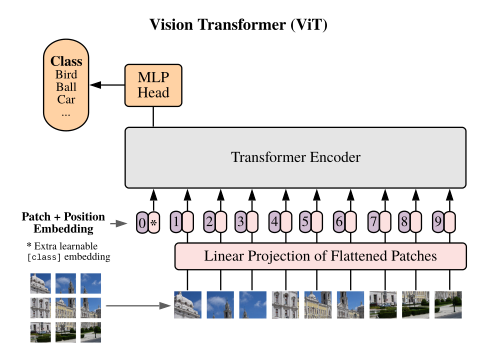

In [16]:
# class PatchEmbedding(nn.Module):
#     def __init__(self, img_size = 32, patch_size = 4, in_chans = 3, embed_dim = 768):
#         super().__init__()
#         self.img_size   = img_size
#         self.patch_size = patch_size    # P
#         self.in_chans   = in_chans      # C
#         self.embed_dim  = embed_dim     # D

#         self.num_patches = (img_size // patch_size) ** 2        # N = H*W/P^2
#         self.flatten_dim = (patch_size **2) * in_chans   # P^2*C

#         self.proj = nn.Linear(self.flatten_dim, embed_dim) # (P^2*C,D)

#         self.position_embed = nn.Parameter(torch.zeros(1, 1 + self.num_patches, embed_dim))
#         self.class_embed    = nn.Parameter(torch.zeros(1, 1, embed_dim))

#     def forward(self, x):
#         B, C, H, W = x.shape

#         x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
#         x = x.reshape(1, -1, self.patch_size, self.patch_size)
#         x = x.permute(0, 2, 1, 3).reshape(B, self.num_patches, -1)

#         x = self.proj(x)

#         cls_emb = self.class_embed.expand(B, -1, -1)
#         x = torch.cat((cls_emb, x), dim = 1)

#         x = x + self.position_embed
#         return x
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, dim, H/P, W/P)
        x = x.flatten(2)  # (B, dim, N)
        x = x.transpose(1, 2)  # (B, N, dim)
        return x


In [17]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim = 768, num_heads = 4, bias = False, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0

        self.embed_dim   = embed_dim
        self.num_heads   = num_heads
        self.head_dim    = embed_dim // num_heads

        self.query   = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.key     = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.value   = nn.Linear(embed_dim, embed_dim, bias=bias)

        self.out     = nn.Linear(embed_dim, embed_dim, bias=bias)

        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, _ = x.size()

        q = self.query(x).view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.key(x).view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.value(x).view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # do NOT use causal attention as we are not dealing with sequential data (image patches are unordered)
        attn = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_dim))
        attn = attn.softmax(dim=-1)

        out = (attn @ v).permute(0, 2, 1, 3).reshape(B, N, self.embed_dim)

        out = self.out(out)

        return out


In [18]:
class MLP(nn.Module):
    def __init__(self, embed_dim = 768, bias = False, dropout = 0.1):
        super().__init__()
        self.c_fc = nn.Linear(embed_dim, embed_dim * 4, bias=bias)
        self.gelu = nn.GELU() #Activation function for the multi-layer perceptron.
        self.c_proj = nn.Linear(embed_dim * 4, embed_dim, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)

        return x

class Block(nn.Module):

    def __init__(self, embed_dim = 768, bias = False):
        super().__init__()
        self.ln_1 = nn.LayerNorm(embed_dim, bias=bias)
        self.attn = SelfAttention(embed_dim, bias=bias)
        self.ln_2 = nn.LayerNorm(embed_dim, bias=bias)
        self.mlp = MLP(embed_dim, bias=bias)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x




In [19]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=-1)  # (B, N, D)
        q, k, v = map(lambda t: t.reshape(B, N, self.heads, D // self.heads).transpose(1, 2), qkv)
        scores = (q @ k.transpose(-2, -1)) * self.scale
        attn = scores.softmax(dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, D)
        return self.dropout(self.to_out(out))

In [20]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(dim, heads, dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout),
        )
    def forward(self, x):
      # Apply attention with residual
      x = x + self.attn(self.norm1(x))
      # Apply MLP with residual
      x = x + self.mlp(self.norm2(x))
      return x

In [21]:
class ViT(nn.Module):
    def __init__(self, image_size=32, patch_size=4, dim=256, depth=6, heads=8, mlp_dim=512, num_classes=10, dropout=0.):
        super().__init__()
        self.patch_embed = PatchEmbedding(image_size, patch_size, in_channels=3, dim=dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        self.encoder = nn.Sequential(*[
            TransformerEncoderBlock(dim, heads, mlp_dim, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)  # (B, N, D)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, N+1, D)
        x = x + self.pos_embed
        x = self.encoder(x)
        x = self.norm(x)
        return self.mlp_head(x[:, 0])





In [24]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT(image_size=IMAGE_SIZE, patch_size=PATCH_SIZE, dim=DIM,
            depth=DEPTH, heads=HEADS, mlp_dim=MLP_DIM,
            num_classes=NUM_CLASSES, dropout=DROPOUT).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
train_losses = []
test_accuracies =[]

for epoch in range(EPOCHS):
    print(epoch)
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(avg_loss)

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            pred = out.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    test_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {acc:.2f}%")


0
Epoch 1/10, Loss: 2.1026, Train Acc: 20.50%, Test Acc: 30.42%
1
Epoch 2/10, Loss: 1.8518, Train Acc: 32.97%, Test Acc: 36.63%
2
Epoch 3/10, Loss: 1.7444, Train Acc: 37.26%, Test Acc: 40.73%
3
Epoch 4/10, Loss: 1.6633, Train Acc: 40.60%, Test Acc: 42.93%
4
Epoch 5/10, Loss: 1.6039, Train Acc: 42.98%, Test Acc: 45.72%
5
Epoch 6/10, Loss: 1.5611, Train Acc: 44.13%, Test Acc: 46.84%
6
Epoch 7/10, Loss: 1.5180, Train Acc: 45.44%, Test Acc: 46.23%
7
Epoch 8/10, Loss: 1.4955, Train Acc: 46.36%, Test Acc: 47.99%
8
Epoch 9/10, Loss: 1.4671, Train Acc: 47.09%, Test Acc: 48.67%
9
Epoch 10/10, Loss: 1.4529, Train Acc: 47.64%, Test Acc: 48.72%


False


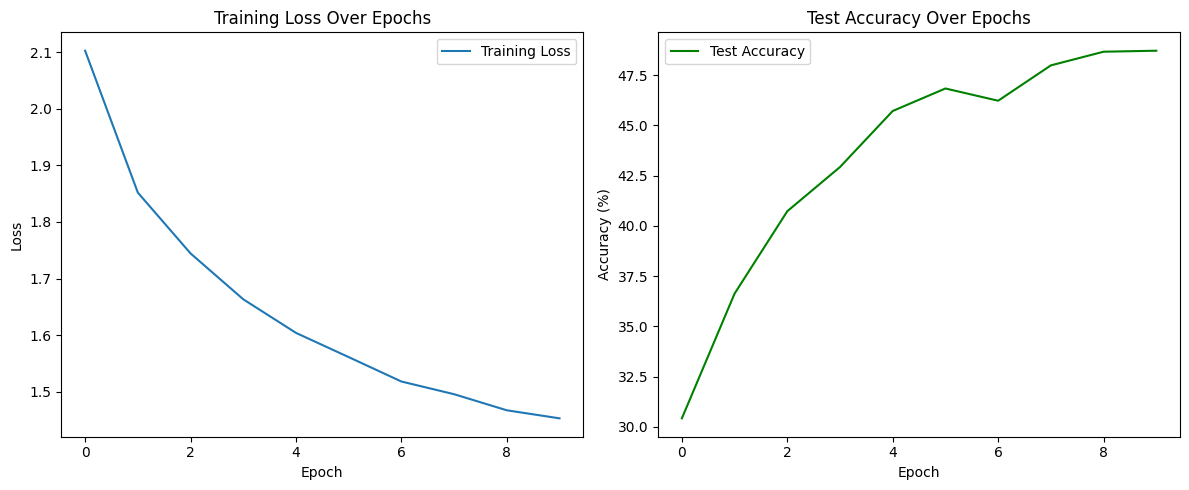

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Test Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()